In [1]:
from datetime import datetime
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random

from model import get_train_augmentation_model, get_test_augmentation_model
from model import Patches, PatchEncoder, create_encoder, create_decoder, MaskedAutoencoder
from model import TrainMonitor, WarmUpCosine

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

DATASET = "CIFAR10"

if DATASET == "CIFAR10":
    from params_CIFAR10 import *
if DATASET == "MNIST":
    from params_MNIST import *


model_base_path = Path(MODEL_SAVE_PATH).absolute()
now = datetime.now().strftime("%Y%m%d_%H-%M-%S")
model_base_path = model_base_path / now
if not model_base_path.exists():
    model_base_path.mkdir(parents=True)
model_filepath = model_base_path / f"complete_model"    # the full AE model will be saved
checkpoint_path = model_base_path / 'checkpoints' / 'ckpt'   # checkpoints will be saved here
weights_path = model_base_path / 'weights' / 'model_weights'   # weights will be saved here
train_monitor_progress_path = model_base_path / "train_progress"    # path where the training monitor callback images will be saved
if not train_monitor_progress_path.exists():
    train_monitor_progress_path.mkdir(parents=True)

c:\Users\klau\Anaconda3\envs\vit_encoder\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# CIFAR-10

In [2]:
# Load and prepare the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)


Training samples: 40000
Validation samples: 10000
Testing samples: 10000


Index selected: 102.


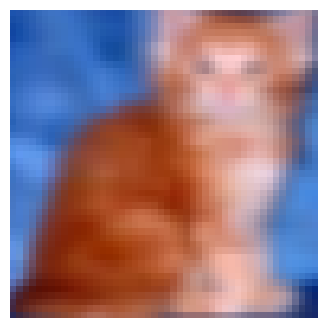

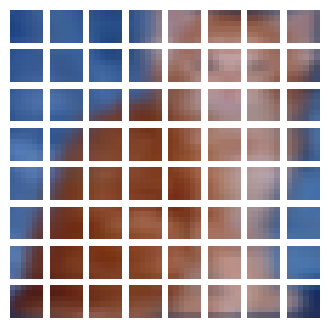

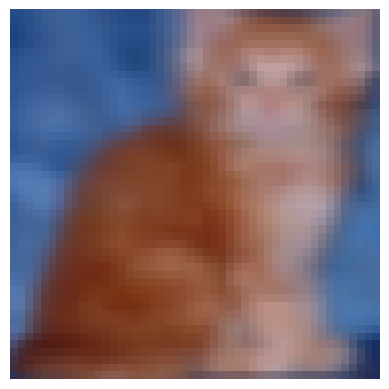

In [3]:
# Visualize the image patches:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model(INPUT_SHAPE, IMAGE_SIZE)
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches(PATCH_SIZE, IMAGE_CHANNELS)

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()


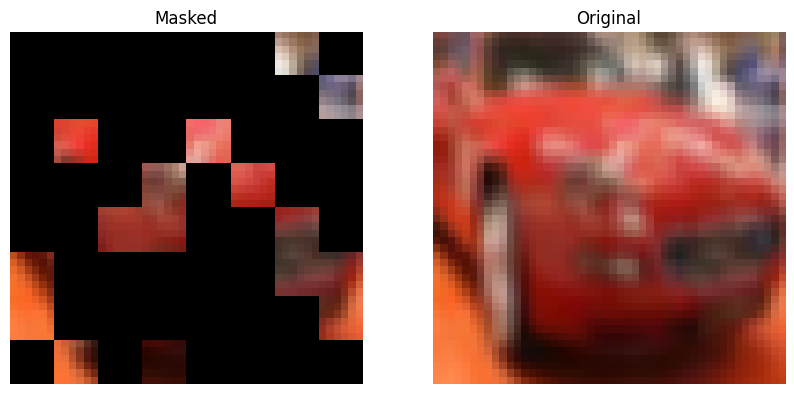

In [4]:
# Visulize the masked image:
# Create the patch encoder layer.
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, 
                             projection_dim=ENC_PROJECTION_DIM, 
                             mask_proportion=MASK_PROPORTION, 
                             img_channels=IMAGE_CHANNELS)

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()


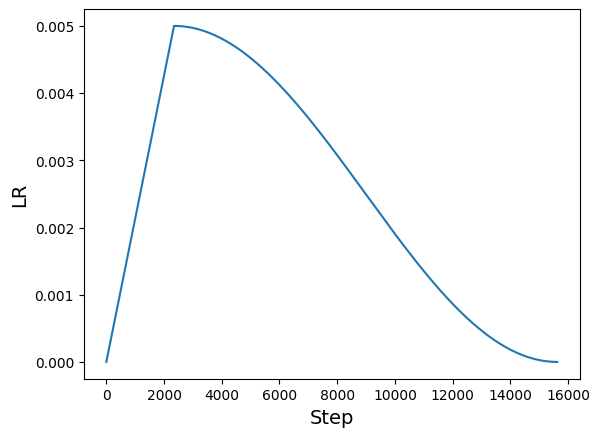

In [5]:
# Test the LR scheduler
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [6]:
train_augmentation_model = get_train_augmentation_model(INPUT_SHAPE, IMAGE_SIZE)
test_augmentation_model = get_test_augmentation_model(IMAGE_SIZE)
patch_layer = Patches(PATCH_SIZE, IMAGE_CHANNELS)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, 
                             projection_dim=ENC_PROJECTION_DIM, 
                             mask_proportion=MASK_PROPORTION,
                             img_channels=IMAGE_CHANNELS)
encoder = create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS, 
                         enc_projection_dim=ENC_PROJECTION_DIM, enc_transformer_units=ENC_TRANSFORMER_UNITS, 
                         norm_eps=LAYER_NORM_EPS)
decoder = create_decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE, img_channels=IMAGE_CHANNELS, num_patches=NUM_PATCHES,
                         enc_projection_dim=ENC_PROJECTION_DIM, dec_projection_dim=DEC_PROJECTION_DIM, dec_transformer_units=DEC_TRANSFORMER_UNITS, 
                         norm_eps=LAYER_NORM_EPS)

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

# Assemble the callbacks.
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
# to restore the model from this checkpoint (weights only), use: model.load_weights(checkpoint_path)

train_callbacks = [TrainMonitor(next(iter(test_ds)), epoch_interval=5, save_path=train_monitor_progress_path), model_checkpoint_callback]

157/157 [==============================] - ETA: 0s - loss: 0.0511 - mae: 0.1818
Idx chosen: 92


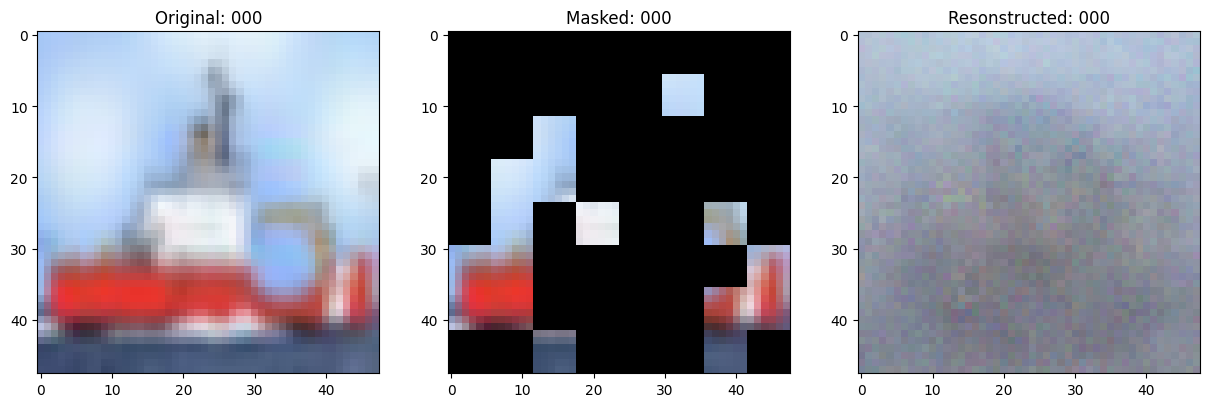

40/40 [==============================] - 30s 744ms/step - loss: 0.0419 - mae: 0.1644
Test Loss: 0.04
Test MAE: 0.16


In [7]:
# TRAINING
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, 
    epochs=1, #EPOCHS
    validation_data=val_ds, 
    callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Test Loss: {loss:.2f}")
print(f"Test MAE: {mae:.2f}")


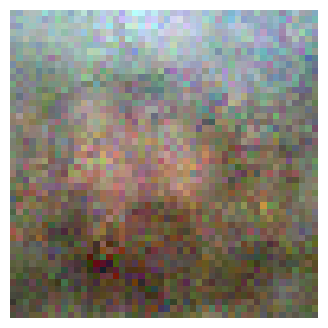

In [8]:
# invoke a forward pass to trigger model building and be sure the input dimensions are known to TF and the model can be saved
test_img = tf.expand_dims(next(iter(test_ds))[0], axis=0)
reconstructed_img = mae_model(test_img)
plt.figure(figsize=(4, 4))
plt.imshow(keras.utils.array_to_img(reconstructed_img[0, ...]))
plt.axis("off")
plt.show()


In [9]:
# Save the final trained model.
mae_model.save(model_filepath, save_traces=False)  # This will save the entire model (architecture, weights, optimizer state)
# Save model weights only
mae_model.save_weights(weights_path)

# Load the model.
# custom_objects = {"WarmUpCosine": WarmUpCosine, "Patches": Patches, "PatchEncoder": PatchEncoder, "MaskedAutoencoder": MaskedAutoencoder} 
# mae_model = keras.models.load_model(model_filepath, custom_objects=custom_objects)

mae_model.summary()

INFO:tensorflow:Assets written to: saved_models\ViT_CIFAR10\20230525_13-06-11\complete_model\assets
Model: "masked_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 train_data_augmentation (Se  (None, 48, 48, 3)        0         
 quential)                                                       
                                                                 
 test_data_augmentation (Seq  (None, 48, 48, 3)        0         
 uential)                                                        
                                                                 
 patches_1 (Patches)         multiple                  0         
                                                                 
 patch_encoder_1 (PatchEncod  multiple                 22252     
 er)                                                             
                                                                 
 mae_encoder (

In [12]:
# Test Model Loading
# Load the model.
custom_objects = {"WarmUpCosine": WarmUpCosine, "Patches": Patches, "PatchEncoder": PatchEncoder, "MaskedAutoencoder": MaskedAutoencoder} 
mae_model2 = keras.models.load_model(model_filepath, custom_objects=custom_objects)

mae_model2.summary()

mae_model3 = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)
mae_model3.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
load_status = mae_model3.load_weights(weights_path)
# `assert_consumed` can be used as validation that all variable values have been
# restored from the checkpoint. See `tf.train.Checkpoint.restore` for other
# methods in the Status object.
# load_status.assert_consumed()
mae_model3.summary()

Model: "masked_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 train_data_augmentation (Se  (None, 48, 48, 3)        0         
 quential)                                                       
                                                                 
 test_data_augmentation (Seq  (None, 48, 48, 3)        0         
 uential)                                                        
                                                                 
 patches_1 (Patches)         multiple                  0         
                                                                 
 patch_encoder_1 (PatchEncod  multiple                 22252     
 er)                                                             
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                

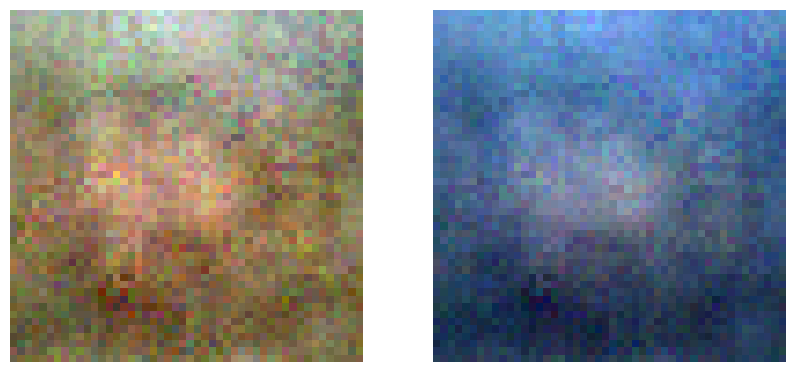

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
reconstructed_img = mae_model(test_img)
ax[0].imshow(keras.utils.array_to_img(reconstructed_img[0, ...]))
ax[0].axis("off")
reconstructed_img2 = mae_model2(test_img)
# plt.figure(figsize=(4, 4))
ax[1].imshow(keras.utils.array_to_img(reconstructed_img2[0, ...]))
ax[1].axis("off")
plt.show()

#### Extracting and using the ViT Encoder for linear probing 
#### (i.e. adding a classification layer to the encoder stack)

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),     # or just INPUT_SHAPE
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()


ValueError: All layers in a Sequential model should have a single output tensor. For multi-output layers, use the functional API.

In [ ]:
# Prepare datasets for linear probing
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)


In [ ]:
# Perform linear probing

linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")



#### Extracting and using the ViT Encoder as stand alone preprocessor for further classificators

In [10]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Switch the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
vit_encoder = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),     # or just INPUT_SHAPE
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
    ],
    name="vit_encoder",
)

# The encoder should not be trainable
for layer in vit_encoder.layers[:-2]:
    layer.trainable = False

# post-train the vit_encoder batchnorm layer
# vit_encoder.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )
# vit_encoder.fit(train_ds, validation_data=val_ds, epochs=5)

vit_encoder.summary()

Model: "vit_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_1 (Patches)         (None, 64, 108)           0         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 64, 128)          22252     
 er)                                                             
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                       

In [ ]:
# prepare the data
def prepare_data(images, labels, is_vit_train=False):   #normaly there is no casewhere we wan to retrain the encoder here
    if is_vit_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_vit_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# (x_train, y_train), (x_val, y_val) = (
#     (x_train[:40000], y_train[:40000]),
#     (x_train[40000:], y_train[40000:]),
# )
train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_val, y_val, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [ ]:
# train a sklearn SVM classifier on the features extracted from the encoder
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score

x_train_features = vit_encoder.predict(x_train)
